# Building a stock database using Polygon and Sharadar
*Python 3.11.4*

The goal is to create a financial database of 1-minute OHLCV data from 2005 and beyond, delisted or listed, for common stocks and ADR common stocks. I use Polygon for price data, which is "ticker-centric". All data from Polygon is point-in-time by ticker. This means we have to take care of renamings ourselves. Some vendors already do renamings (e.g. Tiingo). And almost all of the vendors that do renamings have a small bit of survivorship-bias, because when a ticker is re-used they do not have them.

With the Alpaca notebooks (which are now in the archive) I tried to convert tick quote data to quotes and then merge them with bars to get a realistic bid-ask spread. I have decided to not use quote data anymore. It is simply too expensive, cumbersome or simply impossible. I would have to download ALL tick data in order to get quotebars. Instead, I will just trade using 1-minute OHLC. When backtesting, I will assume a spread of 1 tick or a few cents. This is okay, because I simply will not trade HFT or systems with an average profit less than 0.3% for liquid stocks or less than 0.1% for liquid futures/CFDs. High frequency systems also won't work in Europe due to almost not having access to PFOF brokers. I also will avoid illiquid stocks. If I want a more realistic estimate, I will sample the bid-ask spread throughout the day. 

All Polygon data will be stored in <code>../../../data/polygon/</code>. This map contains a <code>raw</code> and <code>processed</code> folder. The <code>raw</code> folder will contain the folders <code>m1</code>, <code>adjustments</code>, <code>fundamentals</code>,<code>tickers</code> and <code>cleaned</code>. The <code>processed</code> folder will contain the folders <code>m1</code>, <code>m5</code>, <code>h1</code>, <code>d1</code>, <code>w1</code>, <code>m1</code> and <code>fundamentals</code>. Processed data is always adjusted. Raw data is never. Some other data, such as market hours that are not specific to a data vendor, are stored in <code>../../../data/other/</code>. The folders have to be created manually.

**Note: Fundamentals are postponed because I want to focus on getting price data first. I also will postpone cleaning price data because I cannot afford the subscription for tick data.**

In the <code>../../../data/</code> folder the aggregated ticker lists <code>tickers_v{version}.csv</code>are stored. Version 1 is the first aggregated ticker list which has a lot of problems. Version 2 takes care of these problems. Version 3 adds the most liquid ETFs in their category. Version 4 takes care of renamings.

*Warning: If you think we can just loop through all tickers to get all price and fundamental data, you are in for a surprise. Yes even with the well-documented API from Polygon.*

The series of notebooks:
1. Get a list of tickers, ticker renamings and market hours.
2. Get adjustment factors.
3. Download raw 1-minute OHLC data. After converting the Unix timestamp to ET-naive datetimes, the columns are <code>["datetime", "open", "high", "low", "close", "volume"]</code>.
4. Clean suspicious bars with quote/tick data. All cleaned bars are stored in the folder <code>cleaned</code>. **(Postponed because I currently cannot afford the tick data subscription)**
5. Process raw data. When data is downloaded for the first time or updated, the *entire* data set needs be processed (for the updated tickers). This is because if new adjustments come in due to dividend or split data, the entire history needs to be readjusted. Processed data will contain the columns <code>["open", "high", "low", "close", "close_original", "volume", "tradeable", "cleaned", "halted"]</code>. All prices are adjusted, except <code>close_original</code>. The reason we need the original close price is for price filters and fundamentals. Processed data should have no gaps. If data is forward filled, the backtester should not trade these 'stale' prices. Either there have been no trades in the minute or the stock is halted. That is what the <code>tradeable</code> and <code>halted</code> flag is for. The <code>cleaned</code> flag is for if the bar has been cleaned.
6. Process ticker changes.
7. Aggregate processed 1-minute bars to higher timeframes.
8. Get fundamentals from Polygon and Sharadar. **(Postponed)**

*Note: a data point at 15:59 with OHLC means that the open was at 15:59:00 and close at 16:00:00. So daily data does not contain the 16:00:00 minute bar. My polygon key is in <code>../../../data/polygon/secret.txt</code>, this file has to be created manually, just like the folders.*

In [1]:
#####
from polygon.rest import RESTClient
from datetime import datetime, date, time, timedelta
from pytz import timezone
import os
import pytz
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import mplfinance as mpf

DATA_PATH = "../../../data/polygon/"

START_DATE = datetime(2019, 1, 1).date() 
END_DATE = datetime(2023, 9, 1).date()

# There is no guarantee that START_DATE and END_DATE is a trading date. We will handle this later.

with open(DATA_PATH + "secret.txt") as f:
    KEY = next(f).strip()

client = RESTClient(api_key=KEY)

The free tier has a rate limit of 5/minute. Just listing the tickers already goes above the limit. So I will start with the cheapest (29/month) subscription. When I have everything setup, I will upgrade to the highest tier. Then when I have acquired all data, I will likely downgrade to the cheapest subscription just for updates.

The current goal is to download all stocks from 2021-6-1 to 2023-8-18. If I am succesful with that, I will try to get it from the last 5 years which is the maximum for the "starter" subscription. Then finally I can download it all.

# 1. Getting all tickers

We are only interested in common stocks (CS) and ADR commons (ADRC) in the US only that are not OTC. It must also include the delisted stocks. So we need to get 4 different set of tickers: CS+active, CS+inactive, ADRC+active, ADRC+inactive. Setting the <code>asset_class</code> to "stocks" only pulls non-OTC tickers. The <code>list_tickers</code> returns an iterator. Every iteration is 1 request with the specified <code>limit</code>.


In [3]:
print(pd.DataFrame(client.get_ticker_types(asset_class="stocks", locale="us")))

   asset_class     code                            description locale
0       stocks       CS                           Common Stock     us
1       stocks      PFD                        Preferred Stock     us
2       stocks  WARRANT                                Warrant     us
3       stocks    RIGHT                                 Rights     us
4       stocks     BOND                         Corporate Bond     us
5       stocks      ETF                   Exchange Traded Fund     us
6       stocks      ETN                   Exchange Traded Note     us
7       stocks      ETV                Exchange Traded Vehicle     us
8       stocks       SP                     Structured Product     us
9       stocks     ADRC     American Depository Receipt Common     us
10      stocks     ADRP  American Depository Receipt Preferred     us
11      stocks     ADRW   American Depository Receipt Warrants     us
12      stocks     ADRR     American Depository Receipt Rights     us
13      stocks     F

In [4]:
ticker_list_iterator_active = client.list_tickers(type="CS", date=END_DATE.isoformat(), active=True, market='stocks', limit=1000)
ticker_list_iterator_delisted = client.list_tickers(type="CS", date=END_DATE.isoformat(), active=False, market='stocks', limit=1000)
ticker_list_iterator_active_adr = client.list_tickers(type="ADRC", date=END_DATE.isoformat(), active=True, market='stocks', limit=1000)
ticker_list_iterator_delisted_adr = client.list_tickers(type="ADRC", date=END_DATE.isoformat(), active=False, market='stocks', limit=1000)
tickers_active = pd.DataFrame(ticker_list_iterator_active)
tickers_delisted = pd.DataFrame(ticker_list_iterator_delisted)
tickers_active_adr = pd.DataFrame(ticker_list_iterator_active_adr)
tickers_delisted_adr = pd.DataFrame(ticker_list_iterator_delisted_adr)

In [5]:
tickers_active.head(3)

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,True,0001090872,BBG000C2V3D6,usd,None,None,None,None,2023-08-31T00:00:00Z,us,stocks,Agilent Technologies Inc.,XNYS,BBG001SCTQY4,A,CS,None
1,True,0001675149,BBG00B3T3HD3,usd,None,None,None,None,2023-09-01T00:00:00Z,us,stocks,Alcoa Corporation,XNYS,BBG00B3T3HF1,AA,CS,None
2,True,0001829432,None,usd,None,None,None,None,2023-09-01T00:00:00Z,us,stocks,Ares Acquisition Corporation,XNYS,None,AAC,CS,None


In [6]:
tickers_delisted.head(3)

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,False,0000004281,None,usd,None,None,None,2016-10-07T00:00:00Z,2016-10-07T00:00:00Z,us,stocks,ALCOA INC,XNYS,None,AA,CS,None
1,False,0000004281,None,usd,None,None,None,2016-11-01T00:00:00Z,2016-11-01T00:00:00Z,us,stocks,"Alcoa, Inc.",XNYS,None,AA,CS,None
2,False,0001011006,BBG000KB2D74,usd,None,None,None,2019-10-07T00:00:00Z,2019-10-07T00:00:00Z,us,stocks,Altaba Inc. Common Stock,XNAS,BBG001S8V781,AABA,CS,None


In [7]:
tickers_active_adr.head(3)

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,True,0001420529,BBG000V2S3P6,usd,None,None,None,None,2023-08-28T00:00:00Z,us,stocks,ATA Creativity Global American Depositary Shares,XNAS,BBG001T125S9,AACG,ADRC,None
1,True,0001492074,BBG00XRJJLG2,usd,None,None,None,None,2023-08-28T00:00:00Z,us,stocks,Abcam plc American Depositary Shares,XNAS,BBG00XRJJM98,ABCM,ADRC,None
2,True,0001565025,BBG000BN5VZ4,usd,None,None,None,None,2023-08-28T00:00:00Z,us,stocks,AMBEV S.A.,XNYS,BBG005KLVT74,ABEV,ADRC,None


In [8]:
tickers_delisted_adr.head(3)

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,False,0001611787,BBG00K6FMBQ8,usd,None,None,None,2018-02-12T00:00:00Z,2018-02-12T00:00:00Z,us,stocks,Advanced Accelerator Applications S.A. America...,XNAS,BBG007K5CVB6,AAAP,ADRC,None
1,False,0001091587,BBG000DK5Q25,usd,None,None,None,2023-05-23T00:00:00Z,2023-05-23T00:00:00Z,us,stocks,ABB Ltd.,XNYS,BBG001SDDMX9,ABB,ADRC,None
2,False,0001617582,None,usd,None,None,None,2018-06-13T00:00:00Z,2018-06-13T00:00:00Z,us,stocks,Ablynx NV American Depositary Shares,XNAS,None,ABLX,ADRC,None


In [7]:
tickers = pd.concat([tickers_active, tickers_delisted, tickers_active_adr, tickers_delisted_adr]).reset_index()

Some basic checks to check for weird things:

In [8]:
# Check na values
tickers.isna().sum()

index                       0
active                      0
cik                       649
composite_figi           6175
currency_name               0
currency_symbol         13871
base_currency_symbol    13871
base_currency_name      13871
delisted_utc             5905
last_updated_utc            0
locale                      0
market                      0
name                        0
primary_exchange            0
share_class_figi         6175
ticker                      0
type                        0
source_feed             13871
dtype: int64

In [9]:
# Check unique values 
print(tickers['currency_name'].unique()) # Should be USD only
print(tickers['locale'].unique()) # Should be US only

['usd']
['us']


In [12]:
# Clean up and rearrange columns
tickers_active = tickers_active[['ticker', 'name', 'active', 'delisted_utc', 'last_updated_utc', 'cik', 'composite_figi', 'type']]
tickers_delisted = tickers_delisted[['ticker', 'name', 'active', 'delisted_utc', 'last_updated_utc', 'cik', 'composite_figi', 'type']]
tickers_active_adr = tickers_active_adr[['ticker', 'name', 'active', 'delisted_utc', 'last_updated_utc', 'cik', 'composite_figi', 'type']]
tickers_delisted_adr = tickers_delisted_adr[['ticker', 'name', 'active', 'delisted_utc', 'last_updated_utc', 'cik', 'composite_figi', 'type']]
tickers = tickers[['ticker', 'name', 'active', 'delisted_utc', 'last_updated_utc', 'cik', 'composite_figi', 'type']]

## 1.1 Ticker issues

Check if all tickers are unique:

In [13]:
ticker_frequency = tickers.pivot_table(columns=['ticker'], aggfunc='size')
ticker_frequency[ticker_frequency > 1]

ticker
AA      3
AAC     4
AAN     4
AAU     2
AAV     2
       ..
ZME     2
ZOM     2
ZSAN    3
ZTR     2
ZYME    2
Length: 1978, dtype: int64

Apparently they are not unique. There are more than 1800 duplications. Maybe it is because tickers get recycled after delisting?

In [14]:
ticker_frequency_active = tickers_active.pivot_table(columns=['ticker'], aggfunc='size')
ticker_frequency_active[ticker_frequency_active > 1]

Series([], dtype: int64)

There are indeed no duplicates in the active stocks. The tickers are recycled:

In [15]:
tickers[tickers['ticker'] == "AAN"]


,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type
10,AAN,"The Aaron's Company, Inc.",True,None,2023-08-28T00:00:00Z,0001821393,BBG00WCNDCZ6,CS
5492,AAN,AARON'S INC CL B,False,2010-12-14T00:00:00Z,2010-12-14T00:00:00Z,0000706688,None,CS
5493,AAN,"Aaron's, Inc.",False,2020-10-19T00:00:00Z,2020-10-19T00:00:00Z,0000706688,BBG00JZD1964,CS
5494,AAN,"Aaron''s Holdings Company, Inc.",False,2020-12-01T00:00:00Z,2020-12-01T00:00:00Z,0001821393,BBG00XYJSN34,CS


We need to keep this in mind if we download historical data. Because we cannot just loop through all tickers and then store them in a csv. Because then the first ones will be overwritten.

The cik is also not unique.

In [16]:
ticker_frequency = tickers.pivot_table(columns=['cik'], aggfunc='size')
ticker_frequency[ticker_frequency > 1]

cik
0000002186    3
0000002491    2
0000003197    2
0000003327    3
0000003453    2
             ..
0001951067    2
0001951222    2
0001955520    2
0001965040    2
0001968915    2
Length: 2416, dtype: int64

In [17]:
tickers[tickers['cik'] == "0000002186"]

,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type
707,BKTI,BK Technologies Corporation,True,None,2023-08-28T00:00:00Z,0000002186,BBG00NKSM4N7,CS
6363,BKTI,BK Technologies Corporation,False,2023-04-24T00:00:00Z,2023-04-24T00:00:00Z,0000002186,BBG00NKSM4N7,CS
11432,RWC,RELM Wireless Corporation,False,2018-06-05T00:00:00Z,2018-06-05T00:00:00Z,0000002186,None,CS


What we can do to handle delisted tickers (e.g. multiple AAC) when downloading is:
- For the active tickers, just save the data in AAC.csv, as there are no duplicate tickers.
- For the inactive tickers, we will add the delisted year and month to the end of the ticker: AAC-2009-01.csv. This is also what Norgate Data does. If there are 2 delistings from the same ticker in the same month, also the day will be added: AAC-2009-01-01
- We need to keep in mind that it is possible for a ticker to go to OTC and then back (see HTZ on TradingView). We will treat these cases as two different stocks, such that we do not trade OTC. We won't even use the OTC data.

*Note: I decided to name delisted and listed tickers with the ticker + start date. Because the start date never changes, while the end date does. This makes things easier, although not as elegant.*

In [18]:
tickers.sort_values(by=['ticker'], inplace=True)
# We are not interested in stocks that were delisted before the start date
tickers['delisted_utc'] = pd.to_datetime(tickers['delisted_utc'])
tickers['last_updated_utc'] = pd.to_datetime(tickers['last_updated_utc'])
tickers = tickers[(tickers['delisted_utc'].dt.date > START_DATE) | tickers['delisted_utc'].isnull()]
tickers.reset_index(inplace=True, drop=True)
tickers

,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type
0,A,Agilent Technologies Inc.,True,NaT,2023-08-28 00:00:00+00:00,0001090872,BBG000C2V3D6,CS
1,AA,Alcoa Corporation,True,NaT,2023-08-28 00:00:00+00:00,0001675149,BBG00B3T3HD3,CS
2,AAC,Ares Acquisition Corporation,True,NaT,2023-08-28 00:00:00+00:00,0001829432,None,CS
3,AACG,ATA Creativity Global American Depositary Shares,True,NaT,2023-08-28 00:00:00+00:00,0001420529,BBG000V2S3P6,ADRC
4,AACI,Armada Acquisition Corp. I Common Stock,True,NaT,2023-08-28 00:00:00+00:00,0001844817,BBG011XR7306,CS
...,...,...,...,...,...,...,...,...
8178,ZY,Zymergen Inc. Common Stock,False,2022-10-20 00:00:00+00:00,2022-10-20 00:00:00+00:00,0001645842,BBG0077HPN74,CS
8179,ZYME,Zymeworks Inc.,False,2022-10-13 00:00:00+00:00,2022-10-13 00:00:00+00:00,0001403752,BBG00GD15LJ5,CS
8180,ZYME,Zymeworks Inc.,True,NaT,2023-08-28 00:00:00+00:00,0001937653,BBG019XSYC89,CS
8181,ZYNE,"Zynerba Pharmaceuticals, Inc",True,NaT,2023-08-28 00:00:00+00:00,0001621443,BBG007BBS8B7,CS


We now have the end dates. But to download the data we also need the start date. Let's try to get the start date of META. To get them we could use the <code>Ticker Details</code> endpoint. But this gets the *list date*. This is not necessarily the same as the start date of a ticker. E.g. FB changed their ticker to META, but what does ticker details give? We want 2022.

(If a ticker changes, just like normal, we treat them as 2 different stocks. In the end, we should thus get a META.csv and a FB.csv. We can merge them later *after* downloading all data. The purpose of the ticker list is to know what data to download.)

In [19]:
meta_details = client.get_ticker_details(ticker = "META")
meta_details.list_date

'2012-05-18'

In [20]:
result = client.get_ticker_events(ticker="META")
result

TickerChangeResults(name='Meta Platforms, Inc. Class A Common Stock', composite_figi='BBG000MM2P62', cik='0001326801', events=[{'ticker_change': {'ticker': 'META'}, 'type': 'ticker_change', 'date': '2022-06-09'}, {'ticker_change': {'ticker': 'FB'}, 'type': 'ticker_change', 'date': '2012-05-18'}])

The start date of META is 2022-06-09. But the list date is the one from FB from 2012. We cannot use <code>get_ticker_events</code> because it does not include delisted companies. So to reiterate, our current goal is to get the 2022-06-09 *without* <code>get_ticker_events</code> in order to download the correct data for META.

What happens if we download data from a ticker that has multiple changes? If we use META we expect only data from 2022-06-09 to now. If we use FB we expect data from 2012 to 2022-06-08.

In [21]:
meta_iterator = client.get_aggs(ticker = "META", multiplier = 1, timespan = "day", from_ = "2010-01-01", to = "2023-08-18", limit=50000)
meta_d1 = pd.DataFrame(meta_iterator)
meta_d1["timestamp"] = pd.to_datetime(meta_d1["timestamp"], unit="ms").dt.date
meta_d1.rename(columns={"timestamp": "date"}, inplace=True)
meta_d1


,open,high,low,close,volume,vwap,date,transactions,otc
0,15.0800,15.19,15.042,15.12,334935.0,15.1107,2021-06-30,2101,None
1,15.1300,15.13,14.840,14.89,241629.0,15.0126,2021-07-01,2092,None
2,15.0200,15.10,14.930,15.00,388152.0,15.0224,2021-07-02,4733,None
3,15.0800,15.09,14.870,15.01,685094.0,15.1119,2021-07-06,11269,None
4,15.0601,15.15,14.840,14.89,362538.0,14.9830,2021-07-07,5538,None
...,...,...,...,...,...,...,...,...,...
443,300.9800,306.21,298.250,306.19,15641921.0,303.0529,2023-08-14,206053,None
444,306.1400,307.23,300.030,301.95,11623613.0,302.9223,2023-08-15,171652,None
445,300.1950,301.08,294.280,294.29,18547741.0,297.3013,2023-08-16,261408,None
446,293.0500,296.05,284.950,285.09,23950089.0,289.9367,2023-08-17,311835,None


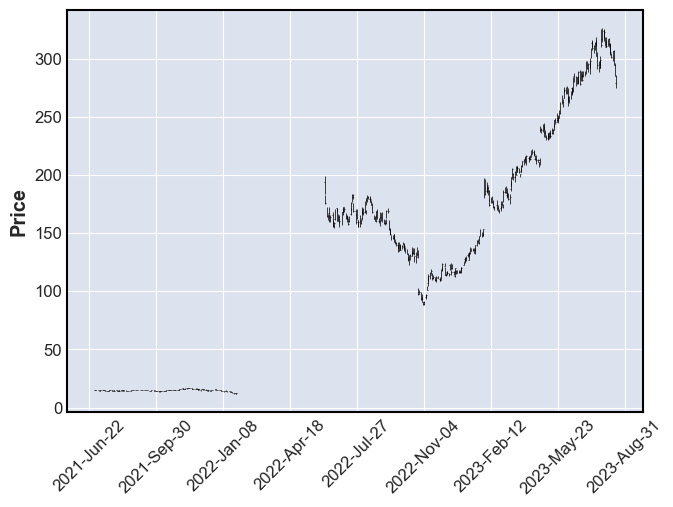

In [24]:
meta_d1.set_index("date", inplace=True)
meta_d1.index = pd.to_datetime(meta_d1.index)
mpf.plot(meta_d1, type='ohlc', show_nontrading=True)

This is absolutely not what we expected. We expected data from either 2022-06-09 (from when the ticker was renamed) or the start of FB (in 2012). This means that there was a ticker named META before FB renamed.

In [22]:
tickers[tickers['ticker'] == "META"]

,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type
4678,META,"Meta Platforms, Inc. Class A Common Stock",True,NaT,2023-08-28 00:00:00+00:00,0001326801,BBG000MM2P62,CS


In [23]:
tickers[tickers['ticker'] == "FB"]

,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type


What? Why is there no META ticker before 2022-06-09? Why is there no FB ticker?

In [25]:
fb_iterator = client.get_aggs(ticker = "FB", multiplier = 1, timespan = "day", from_ = "2010-01-01", to = "2023-08-18", limit=50000)
fb_d1 = pd.DataFrame(fb_iterator)
fb_d1["timestamp"] = pd.to_datetime(fb_d1["timestamp"], unit="ms").dt.date
fb_d1.rename(columns={"timestamp": "date"}, inplace=True)
fb_d1

,open,high,low,close,volume,vwap,date,transactions,otc
0,175.90,179.7901,175.7000,177.64,24216532.0,178.2862,2018-08-30,172773,None
1,177.15,177.6200,174.9815,175.73,18065159.0,175.7343,2018-08-31,135914,None
2,173.50,173.8900,168.8000,171.16,29808971.0,171.1312,2018-09-04,234508,None
3,169.49,171.1250,166.6700,167.18,31203944.0,168.3393,2018-09-05,237150,None
4,166.98,166.9800,160.0000,162.53,41509084.0,163.0707,2018-09-06,322847,None
...,...,...,...,...,...,...,...,...,...
945,188.45,200.9350,187.7300,198.86,31951582.0,195.8094,2022-06-02,336899,None
946,195.98,196.6100,189.7800,190.78,19464993.0,192.0885,2022-06-03,239486,None
947,193.99,196.9200,188.4000,194.25,30574242.0,193.2857,2022-06-06,307707,None
948,191.93,196.5300,191.4900,195.65,18628687.0,194.4583,2022-06-07,204288,None


Why does there exist data for FB if the ticker list does not include it? I thought the <code>Tickers</code> endpoint did not rename but only added new tickers. Apparently that is not the case:

In [26]:
# Before the renaming on 6-9
ticker_list_iterator_fb = client.list_tickers(ticker="FB", type="CS", date="2022-06-08", active=True, market='stocks', limit=1000)
df = pd.DataFrame(ticker_list_iterator_fb)
df

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,True,0001326801,BBG000MM2P62,usd,None,None,None,None,2022-06-08T00:00:00Z,us,stocks,"Meta Platforms, Inc. Class A Common Stock",XNAS,BBG001SQCQC5,FB,CS,None


In [28]:
# After the renaming on 6-9: No FB but we do have META
ticker_list_iterator_fb = client.list_tickers(ticker="FB", type="CS", date="2022-06-09", active=True, market='stocks', limit=1000)
df = pd.DataFrame(ticker_list_iterator_fb)
df

""


In [30]:
ticker_list_iterator_fb = client.list_tickers(ticker="META", type="CS", date="2022-06-09", active=True, market='stocks', limit=1000)
df = pd.DataFrame(ticker_list_iterator_fb)
df

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,True,0001326801,BBG000MM2P62,usd,None,None,None,None,2022-06-09T00:00:00Z,us,stocks,"Meta Platforms, Inc. Class A Common Stock",XNAS,BBG001SQCQC5,META,CS,None


Apparently when a stock renames, the <code>Tickers</code> gets updated by removing the old ticker and adding the new one. It also does not treat it as a delisting (there is no <code>delisted_utc</code>).

The old META is actually an ETF and renamed to METV.

In [33]:
client.get_ticker_details(ticker="META", date="2022-01-01")

TickerDetails(active=True, address=None, branding=None, cik=None, composite_figi='BBG011J1MN62', currency_name='usd', currency_symbol=None, base_currency_name=None, base_currency_symbol=None, delisted_utc=None, description=None, ticker_root='META', ticker_suffix=None, homepage_url=None, list_date='2021-06-30', locale='us', market='stocks', market_cap=None, name='Roundhill Ball Metaverse ETF', phone_number=None, primary_exchange='ARCX', share_class_figi='BBG011J1MP12', share_class_shares_outstanding=60080000, sic_code=None, sic_description=None, ticker='META', total_employees=None, type='ETF', weighted_shares_outstanding=None)

In [34]:
ticker_list_iterator_meta = client.list_tickers(ticker="META", date="2022-01-01", active=True, market='stocks', limit=1000)
df = pd.DataFrame(ticker_list_iterator_meta)
df

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,True,None,BBG011J1MN62,usd,None,None,None,None,2022-01-02T00:00:00Z,us,stocks,Roundhill Ball Metaverse ETF,ARCX,BBG011J1MP12,META,ETF,None


This is quite problematic. The only way to get the end date of FB is to loop through all trading days in <code>Tickers</code> and see when the ticker dissappears. The only way to get the start date of the META or FB is also to loop, but then to track when the ticker appears. Or use the <code>Ticker Events</code> however this only works for current tickers and not delisted ones. So information actually gets lost in the <code>Tickers</code> endpoint.

Who thought that just getting all available tickers would be such a headache? We haven't even begun downloading data.

To summarize:
- Getting data is truly point-in-time, there is no META data for 2022-04-01 (after META ETF, before FB rename), but there is FB data before the META renaming. If the same ticker had different stocks, they are merged when downloading data which we do not want. So we **must** specify a precise start and end date for each stock, else we might get merging from different stocks. And it is not possible to get the start and end dates from <code>list_tickers</code>. Because it simply does not contain the start date. And also not the renamed tickers.
- The <code>Tickers</code> endpoint does **not** include FB in the 'inactive' tickers if we use the current date. So the <code>Tickers</code> is also 'point in time' and **deletes** some data, such as FB.

So we will loop and create an own version of a list of all tickers with start and end dates. This will include FB, which would not be the case if we only used the current date in <code>Tickers</code>. It would also include the old META ETF if it was a stock. This would be impossible to get without looping.

## 1.2 Trading dates and hours
First a small experiment: What is the earliest data that Polygon has? I simply used trial-and-error. The earliest date is 2003-09-10. That is quite a lot. 

In [10]:
ticker_list_iterator = client.list_tickers(date="2003-09-10", active=True, market='stocks', limit=1000)
df = pd.DataFrame(ticker_list_iterator)
len(df)

8204

In order to loop through the trading dates, we still need to get the trading dates. Also there are holidays and early closes. We can infer the holidays by just looking at daily SPY data. But this does not include information about early closes. The goal is to create a csv with dates and the start times of pre-market and regular hours and end times of post-market.

The early closes are listed on [QuantConnect](https://www.quantconnect.com/docs/v2/writing-algorithms/securities/asset-classes/us-equity/market-hours).

So we will first get a list of all trading dates using SPY data. The regular hours always start at 9:30 ET. The start of premarket is 4:00 ET. To test if it is always 4:00 ET we will compare it to the 1-minute SPY data. There are no early or late opens. To get the close we will use 16:00 ET or 13:00 ET if it is an early close. The post-market ends 4 hours after close. We will also test this on the SPY minute data.

In [22]:
###
path = DATA_PATH + "../other/market_hours.csv"

# Get list of trading dates
if os.path.isfile(path):
    # If we already have it we just need to update
    old_market_hours = pd.read_csv(
            path,
            parse_dates=True,
        )
    old_market_hours["date"] = pd.to_datetime(old_market_hours["date"]).dt.date
    old_trading_days = old_market_hours[["date"]]
    last_day_old = old_trading_days['date'].values[-1]

    SPY_d1 = pd.DataFrame(client.get_aggs(ticker = "SPY", multiplier = 1, timespan = "day", from_ = (last_day_old + timedelta(days=1)).isoformat(), to = END_DATE, limit=50000))
    SPY_d1["timestamp"] = pd.to_datetime(SPY_d1["timestamp"], unit="ms").dt.date
    SPY_d1.rename(columns = {"timestamp": "date"}, inplace=True)
    new_trading_days = SPY_d1[["date"]]

    trading_days = pd.concat([old_trading_days, new_trading_days])
    trading_days.drop_duplicates(inplace=True)
    trading_days.sort_values(by='date', inplace=True)
else: 
    # If we do not, download everything
    SPY_d1 = pd.DataFrame(client.get_aggs(ticker = "SPY", multiplier = 1, timespan = "day", from_ = START_DATE, to = END_DATE, limit=50000))
    SPY_d1["timestamp"] = pd.to_datetime(SPY_d1["timestamp"], unit="ms").dt.date
    SPY_d1.rename(columns = {"timestamp": "date"}, inplace=True)
    trading_days = SPY_d1[["date"]]

# Fill with pre-market/regular session
trading_hours = trading_days.copy()
trading_hours["premarket_open"] = time(4)
trading_hours["regular_open"] = time(9, 30)

# Fill in early closes/post-market
early_closes = ['1999-11-26','2000-07-03','2000-11-24','2001-07-03','2001-11-23',
'2001-12-24','2002-07-05','2002-11-29','2002-12-24','2003-07-03','2003-11-28',
'2003-12-24','2003-12-26','2004-11-26','2005-11-25','2006-07-03','2006-11-24',
'2007-07-03','2007-11-23','2007-12-24','2008-07-03','2008-11-28','2008-12-24',
'2009-11-27','2009-12-24','2010-11-26','2011-11-25','2012-07-03','2012-11-23',
'2012-12-24','2013-07-03','2013-11-29','2013-12-24','2014-07-03','2014-11-28',
'2014-12-24','2015-11-27','2015-12-24','2016-11-25','2017-07-03','2017-11-24',
'2017-12-24','2018-07-03','2018-11-23','2018-12-24','2019-07-03','2019-11-29',
'2019-12-24','2020-11-27','2020-12-24','2021-11-26','2022-11-25','2023-07-03',
'2023-11-24','2024-07-03',]
early_closes = [datetime.strptime(date, "%Y-%m-%d").date() for date in early_closes]

trading_hours["regular_close"] = trading_hours["date"].isin(early_closes)
trading_hours["regular_close"] = trading_hours["regular_close"].apply(lambda boolean: time(12, 59) if boolean else time(15, 59))

trading_hours["postmarket_close"] = pd.to_datetime(trading_hours['date'].astype(str) + " " + trading_hours["regular_close"].astype(str)) + timedelta(hours=4)
trading_hours["postmarket_close"] = trading_hours["postmarket_close"].dt.time

trading_hours.set_index("date", inplace=True)
trading_hours.to_csv(path)

# 2023-07-03 was an early close day
trading_hours[trading_hours.index == date(2023, 7, 3)]

,premarket_open,regular_open,regular_close,postmarket_close
date,,,,
2023-07-03,04:00:00,09:30:00,12:59:00,16:59:00


According to [Schwab](https://www.schwab.com/public/schwab/nn/qq/about_extended_hours_trading.html) there are no extended hours on trading days with early closes. I could not find confirmation for this so I will test this claim.

(The reason why we need to be precise about this is for the backtester and for aggregating into daily bars.)

First we create some handy functions for time handling and trading dates. 

In [2]:
#####
# Some handy functions
def datetime_to_unix(dt):
    """
    Converts a ET-naive datetime object to msec timestamp.
            dt : datetime (keyword-only)
    """
    if isinstance(dt, datetime):
        time_ET = timezone("US/Eastern").localize(dt)
        return int(time_ET.timestamp() * 1000)
    else:
        raise Exception("No datetime object specified.")


def download_m1_raw_data(ticker, from_, to, columns, path, client, to_parquet=False):
    """
    Downloads 1-minute data from Polygon, converts to ET-naive time and store to either a
    csv file or Parquet file. Includes extended hours.
        ticker : str
        from_ : datetime or date object
        to : datetime or date object
        columns : list of column names to keep
        path : str, if None is specified, the function returns the df instead.
        to_parquet : bool, if
        client : the RESTClient object
    """
    if all(isinstance(value, date) for value in (from_, to)):
        start_unix = datetime_to_unix(dt=datetime.combine(from_, time(4)))
        end_unix = datetime_to_unix(dt=datetime.combine(to, time(20)))
    elif all(isinstance(value, datetime) for value in (from_, to)):
        start_unix = datetime_to_unix(from_)
        end_unix = datetime_to_unix(to)
    else:
        raise Exception("No datetime or date object specified.")

    m1 = pd.DataFrame(
        client.list_aggs(
            ticker=ticker,
            multiplier=1,
            timespan="minute",
            from_=start_unix,
            to=end_unix,
            limit=50000,
            adjusted=False,
        )
    )
    if not m1.empty:
        m1["timestamp"] = pd.to_datetime(
            m1["timestamp"], unit="ms"
        )  # Convert timestamp to UTC
        m1.rename(columns={"timestamp": "datetime"}, inplace=True)
        m1["datetime"] = m1["datetime"].dt.tz_localize(
            pytz.UTC
        )  # Make UTC aware (in order to convert)
        m1["datetime"] = m1["datetime"].dt.tz_convert("US/Eastern")  # Convert UTC to ET
        m1["datetime"] = m1["datetime"].dt.tz_localize(None)  # Make timezone naive
        m1.set_index("datetime", inplace=True)
        m1 = m1[columns]

        if path is None:
            return m1

        if to_parquet:
            m1.to_parquet(path, engine="pyarrow")
        else:
            m1.to_csv(path)
    else:
        print(
            f"There is no data for {ticker} from {from_.isoformat()} to {to.isoformat()}"
        )
def get_market_dates():
    """
    Get a list of trading dates.
    """
    market_hours = get_market_hours()
    return list(market_hours.index)

def first_trading_date_after_equal(dt):
    """
    Gets first trading day after or equal to input date. Return the input if out of range.
    """
    trading_days = get_market_dates()
    if dt > trading_days[-1]:
        print("Out of range! Returning input.")
        return dt
    while dt not in trading_days:
        dt = dt + timedelta(days=1)
    return dt

def last_trading_date_before_equal(dt):
    """
    Gets last trading day before or equal to input date. Return the input if out of range.
    """
    trading_days = get_market_dates()
    if dt < trading_days[-1]:
        print("Out of range! Returning input.")
        return dt
    while dt not in trading_days:
        dt = dt - timedelta(days=1)
    return dt

def get_market_hours():
    """Retrieves the market hours"""
    market_hours = pd.read_csv(DATA_PATH + "../other/market_hours.csv", index_col=0)
    market_hours.index = pd.to_datetime(market_hours.index).date
    market_hours.premarket_open = pd.to_datetime(market_hours.premarket_open).dt.time
    market_hours.regular_open = pd.to_datetime(market_hours.regular_open).dt.time
    market_hours.regular_close = pd.to_datetime(market_hours.regular_close).dt.time
    market_hours.postmarket_close = pd.to_datetime(market_hours.postmarket_close).dt.time
    return market_hours

def get_market_hours():
    """Retrieves the market hours"""
    market_hours = pd.read_csv(
        DATA_PATH + "../other/market_hours.csv", index_col=0
    )
    market_hours.index = pd.to_datetime(market_hours.index).date
    market_hours.premarket_open = pd.to_datetime(
        market_hours.premarket_open, format="%H:%M:%S"
    ).dt.time
    market_hours.regular_open = pd.to_datetime(
        market_hours.regular_open, format="%H:%M:%S"
    ).dt.time
    market_hours.regular_close = pd.to_datetime(
        market_hours.regular_close, format="%H:%M:%S"
    ).dt.time
    market_hours.postmarket_close = pd.to_datetime(
        market_hours.postmarket_close, format="%H:%M:%S"
    ).dt.time
    return market_hours

In [ ]:
download_m1_raw_data("SPY", from_ = (2019, 1, 2), to = (2023, 8, 18), 
path = DATA_PATH + "/raw/m1/SPY.csv", client=client)

Let's first test if the trading days match between daily and minute bars.

In [44]:
SPY_m1 = pd.read_csv(
        DATA_PATH + "/raw/m1/SPY.csv",
        parse_dates=True,
        index_col="datetime",
        usecols=["datetime"]
    )
market_hours = pd.read_csv(
        DATA_PATH + "../other/market_hours.csv",
        index_col="date",
        parse_dates=True,
    )

market_open_days = set(market_hours.index.date)

# Test for duplicated days in daily data, should be False
print(all(market_hours.duplicated()))

market_open_days_m1 = set(SPY_m1.index.date)

# We might have that there are more data in the market_hours than a specific stock. So we only have to test for containment.
print(market_open_days_m1.issubset(market_open_days))

# In this case however, the daily and minute match exactly:
print(market_open_days.issubset(market_open_days_m1))

False
True
True


Now we will test if the first minute of trading always matches 4:00 ET. As there are not always trades in the first exact minute, we will only look at the hour.

In [42]:
SPY_m1["date"] = SPY_m1.index.date
SPY_m1["hour"] = SPY_m1.index.hour
SPY_m1

,date,hour
datetime,,
2019-01-02 04:00:00,2019-01-02,4
2019-01-02 04:01:00,2019-01-02,4
2019-01-02 04:02:00,2019-01-02,4
2019-01-02 04:03:00,2019-01-02,4
2019-01-02 04:04:00,2019-01-02,4
...,...,...
2023-08-18 19:53:00,2023-08-18,19
2023-08-18 19:56:00,2023-08-18,19
2023-08-18 19:57:00,2023-08-18,19


In [43]:
SPY_open = SPY_m1[~SPY_m1["date"].duplicated()] # By removing duplicates we get the first 1-minute bar of each day.
SPY_open[SPY_open["hour"] != 4]

,date,hour
datetime,,


Hence the pre-market always starts at 4:00 ET. Even for early closes. Now let's check post-market hours for early closes. On 2023-7-3 the market closed at 13:00 ET. We would then expect the post-market to continue for 4 hours until 17:00 ET instead ot 20:00 ET.

In [44]:
SPY_m1[SPY_m1['date'] == date(2023, 7, 3)]

,date,hour
datetime,,
2023-07-03 04:00:00,2023-07-03,4
2023-07-03 04:01:00,2023-07-03,4
2023-07-03 04:02:00,2023-07-03,4
2023-07-03 04:03:00,2023-07-03,4
2023-07-03 04:04:00,2023-07-03,4
...,...,...
2023-07-03 16:43:00,2023-07-03,16
2023-07-03 16:45:00,2023-07-03,16
2023-07-03 16:52:00,2023-07-03,16


Indeed this is the case. The 16:59 minute means that the market closes at 17:00. Let's see if this is the case for all early closes.

In [45]:
SPY_close = SPY_m1[~SPY_m1["date"].duplicated(keep="last")] # By removing duplicates except the last we get the last 1-minute bar of a day.
SPY_close

,date,hour
datetime,,
2019-01-02 19:59:00,2019-01-02,19
2019-01-03 19:59:00,2019-01-03,19
2019-01-04 19:59:00,2019-01-04,19
2019-01-07 19:59:00,2019-01-07,19
2019-01-08 19:59:00,2019-01-08,19
...,...,...
2023-08-14 19:59:00,2023-08-14,19
2023-08-15 19:59:00,2023-08-15,19
2023-08-16 19:59:00,2023-08-16,19


In [46]:
SPY_close[SPY_close["hour"] != 19]

,date,hour
datetime,,
2019-07-03 16:59:00,2019-07-03,16
2019-08-12 20:12:00,2019-08-12,20
2019-11-29 16:59:00,2019-11-29,16
2019-12-24 16:59:00,2019-12-24,16
2020-01-08 20:00:00,2020-01-08,20
2020-04-07 20:00:00,2020-04-07,20
2020-07-01 20:00:00,2020-07-01,20
2020-08-10 20:00:00,2020-08-10,20
2020-08-20 20:00:00,2020-08-20,20


We expected to see only 16:59 (or earlier if no trades happened. But we always expect 16:xx). I will just assume the 20:00:00 is a rounding error that sometimes occurs. If we ignore the 20:00, do the early closes match the list from QuantConnect?

In [47]:
SPY_early_closes = SPY_close[SPY_close["hour"] == 16]
list(SPY_early_closes["date"].values)

[datetime.date(2019, 7, 3),
 datetime.date(2019, 11, 29),
 datetime.date(2019, 12, 24),
 datetime.date(2020, 11, 27),
 datetime.date(2020, 12, 24),
 datetime.date(2021, 11, 26),
 datetime.date(2022, 11, 25),
 datetime.date(2023, 7, 3)]

In [48]:
early_closes[-10:-2]

[datetime.date(2019, 7, 3),
 datetime.date(2019, 11, 29),
 datetime.date(2019, 12, 24),
 datetime.date(2020, 11, 27),
 datetime.date(2020, 12, 24),
 datetime.date(2021, 11, 26),
 datetime.date(2022, 11, 25),
 datetime.date(2023, 7, 3)]

They match. So to summarize: pre-market always starts at 4:00. The market always opens at 9:30. The market closes at 16:00, except on early closes where the close is 13:00. The post-market always closes 4 hours after the regular close.

So far, we have learned some quirks of the Polygon API and established the market hours. We now will loop through all trading dates and get a list of all tickers.

## 1.3 Getting all tickers

Now we can create our ticker list. First we will download all ticker lists from Polygon.

In [17]:
###
def download_tickers(year=None, month=None, day=None, dt=None):
    """
    Get all CS and ADRC, delisted and listed.
        Input must be either
            year : int
            month : int
            day : int
        Or
            dt : datetime or date object (keyword-only)
    """
    if all(isinstance(value, int) for value in (year, month, day)):
        datetime_date = datetime(year, month, day).date()
        
    elif isinstance(dt, datetime):
        datetime_date = dt.date()
    elif isinstance(dt, date):
        datetime_date = dt
    else:
        raise Exception("No year/month/date or datetime object specified.")
    
    date_iso = datetime_date.isoformat()

    ticker_list_iterator_active = client.list_tickers(type="CS", date=date_iso, active=True, market='stocks', limit=1000)
    ticker_list_iterator_delisted = client.list_tickers(type="CS", date=date_iso, active=False, market='stocks', limit=1000)
    ticker_list_iterator_active_adr = client.list_tickers(type="ADRC", date=date_iso, active=True, market='stocks', limit=1000)
    ticker_list_iterator_delisted_adr = client.list_tickers(type="ADRC", date=date_iso, active=False, market='stocks', limit=1000)
    tickers_active = pd.DataFrame(ticker_list_iterator_active)
    tickers_delisted = pd.DataFrame(ticker_list_iterator_delisted)
    tickers_active_adr = pd.DataFrame(ticker_list_iterator_active_adr)
    tickers_delisted_adr = pd.DataFrame(ticker_list_iterator_delisted_adr)

    tickers_all = pd.concat([tickers_active, tickers_delisted, tickers_active_adr, tickers_delisted_adr])
    tickers_all.sort_values(by = "ticker", inplace=True)
    tickers_all.reset_index(inplace=True, drop=True)
    return tickers_all[['ticker', 'name', 'active', 'delisted_utc', 'last_updated_utc', 'cik', 'composite_figi', 'type']]

In [ ]:
###
# Get list of dates of ticker lists that we already have
filenames = next(os.walk(DATA_PATH + "raw/tickers"), (None, None, []))[2] #From https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
available_dates = [date.fromisoformat(date_string.replace(".csv", "")) for date_string in filenames]

trading_days = get_trading_dates()
for day in trading_days:
    # Only download what we do not have
    if day >= START_DATE and day <= END_DATE and day not in available_dates:
        isoformat = day.isoformat()
        tickers = download_tickers(dt = day)
        tickers.to_csv(DATA_PATH + f"raw/tickers/{isoformat}.csv")
        print(f"Downloaded tickers for {isoformat}")

A random ticker list

In [ ]:
tickers_1 = pd.read_csv(
        DATA_PATH + "raw/tickers/2022-06-07.csv",
        index_col=0,
        parse_dates=True
    )
tickers_1

For some reason, even though <code>parse_dates</code> is true, pandas does not convert the date columns to datetime objects. We have to keep this in mind if we read from .csv files using <code>read_csv</code>.

In [14]:
tickers_1['last_updated_utc'].values[2]

'2016-10-07T00:00:00Z'

What we also observe is that the <code>last_updated_utc</code> does not match the date of the ticker list. So this value is not point-in-time. We would expect it all to be 2022-06-09 or earlier, but e.g. for AA this value is 2022-07-20. The <code>delisted_utc</code> is something that only changes once and never updates again. We need neither of those, because we already have <code>end_date</code> which is determined by the Polygon ticker lists. Later when we do have data, we will create a new column <code>start_data</code> and <code>end_data</code> which gives the start and end dates from the available data. We do not trust the <code>last_updated_utc</code> or <code>delisted_utc</code> to be correct.

Now we can finally create our ticker list, which includes all tickers. The process involves looping over all Polygon ticker lists and updating our own one. First some notation: T is our ticker list that we iteratively update using Polygons ticker list. P(i) is the Polygon ticker list from day *i*. 

1. On day 1, our ticker list is the same as the one from Polygon, but with some extra columns. We create a column <code>start_date</code> which is day 1 and <code>end_date</code> with is empty. We are only interested in stocks that were active on that day.
2. For all *i = 2 ... n* days, for the active stocks:
    * **Delistings**: The stocks that are in T but not in P(i) are the stocks that are removed by Polygon (e.g. FB). For these tickers we set the <code>end_date</code> in T to day *i*. 
    * **New listings**: The stocks that are in P(i) but not in T are the new listings. We will append the new stock to T and set the start_date to day *i*.
    * **Everything else**: The stocks that are both in P(i) and T are the stocks that 'continue their listings'. We do nothing.

Two tickers are the 'same' if all fields except <code>last_updated_utc</code> or <code>delisted_utc</code> are the same.

For testing, we will start with 2022-06-08 and update to 2022-06-09. Both FB and META should then be included with the correct start and end dates. The start and end date of FB should be 2022-06-08 and the start date of META should be 2022-06-09. The end date of META should be empty.

In [247]:
day_1 = date(2022, 6, 8)
day_2 = date(2022, 6, 9)

our_tickers = pd.read_csv(
    DATA_PATH + f"raw/tickers/{day_1.isoformat()}.csv",
    index_col=0,
)
our_tickers = our_tickers[["ticker", "name", "active", "cik", "composite_figi", "type"]]
our_tickers = our_tickers[our_tickers["active"] == True]
our_tickers.reset_index(inplace=True, drop=True)

our_tickers["start_date"] = day_1
our_tickers["end_date"] = pd.NaT

tickers_day_2 = pd.read_csv(
    DATA_PATH + f"raw/tickers/{day_2.isoformat()}.csv",
    index_col=0,
)
tickers_day_2 = tickers_day_2[["ticker", "name", "active", "cik", "composite_figi", "type"]]
tickers_day_2 = tickers_day_2[tickers_day_2["active"] == True]
tickers_day_2.reset_index(inplace=True, drop=True)

In [248]:
our_tickers.head()

,ticker,name,active,cik,composite_figi,type,start_date,end_date
0,A,Agilent Technologies Inc.,True,1090872.0,BBG000C2V3D6,CS,2022-06-08,NaT
1,AA,Alcoa Corporation,True,1675149.0,BBG00B3T3HD3,CS,2022-06-08,NaT
2,AAC,Ares Acquisition Corporation,True,1829432.0,NaN,CS,2022-06-08,NaT
3,AACG,ATA Creativity Global American Depositary Shares,True,1420529.0,BBG000V2S3P6,ADRC,2022-06-08,NaT
4,AACI,Armada Acquisition Corp. I Common Stock,True,1844817.0,BBG011XR7306,CS,2022-06-08,NaT


In [249]:
tickers_day_2.head()

,ticker,name,active,cik,composite_figi,type
0,A,Agilent Technologies Inc.,True,1090872.0,BBG000C2V3D6,CS
1,AA,Alcoa Corporation,True,1675149.0,BBG00B3T3HD3,CS
2,AAC,Ares Acquisition Corporation,True,1829432.0,NaN,CS
3,AACG,ATA Creativity Global American Depositary Shares,True,1420529.0,BBG000V2S3P6,ADRC
4,AACI,Armada Acquisition Corp. I Common Stock,True,1844817.0,BBG011XR7306,CS


In [250]:
# Preliminary check: no duplicates
if our_tickers[["ticker", "name", "active", "cik", "composite_figi", "type"]].duplicated().all():
    raise Exception("There are duplicates!")

if tickers_day_2[["ticker", "name", "active", "cik", "composite_figi", "type"]].duplicated().all():
    raise Exception("There are duplicates!")

In [251]:
# DELISTINGS: Get tickers that are in T but not in P(2). This is actually not straightforward (https://stackoverflow.com/questions/28901683/pandas-get-rows-which-are-not-in-other-dataframe). We need to get the rows in tickers_day_2 that are not in our_tickers. We will use the merge function but specifying indicator=True and use a left merge (tickers_day_2 left merge to our_tickers). What gets returned is a dataframe with the flags "left_only", "right_only" and "both". If the indicator is "left_only", it means that it existed in only in the left DataFrame (our_tickers). This is exactly what we need. 
indicator_delisted = our_tickers[["ticker", "name", "active", "cik", "composite_figi", "type"]].merge(tickers_day_2[["ticker", "name", "active", "cik", "composite_figi", "type"]], on=["ticker", "name", "active", "cik", "composite_figi", "type"], 
                   how='left', indicator=True)
indicator_delisted = indicator_delisted["_merge"] # Only get the indicator

delisted_tickers = our_tickers[indicator_delisted == "left_only"] # Only get the delisted tickers

# NEW LISTINGS: Swap the DataFrames
indicator_new = tickers_day_2[["ticker", "name", "active", "cik", "composite_figi", "type"]].merge(our_tickers[["ticker", "name", "active", "cik", "composite_figi", "type"]], on=["ticker", "name", "active", "cik", "composite_figi", "type"], 
                   how='left', indicator=True)
indicator_new = indicator_new["_merge"]
new_tickers = tickers_day_2[indicator_new == "left_only"]

# KEPT LISTINGS: easy
current_tickers = our_tickers[indicator_delisted == "both"]
# current_tickers = tickers_day_2[indicator_new == "both"] # It does not matter which one we choose

In [252]:
delisted_tickers

,ticker,name,active,cik,composite_figi,type,start_date,end_date
1144,CERN,Cerner Corp,True,804753.0,BBG000BFDLV8,CS,2022-06-08,NaT
1799,DYNS,Dynamics Special Purpose Corp. Class A Common ...,True,1854270.0,BBG010WX7ZB3,CS,2022-06-08,NaT
2080,FB,"Meta Platforms, Inc. Class A Common Stock",True,1326801.0,BBG000MM2P62,CS,2022-06-08,NaT
2438,GLAQ,Globis Acquisition Corp. common stock,True,1823383.0,BBG00YCXHR29,CS,2022-06-08,NaT
4518,PRE,Prenetics Global Limited Class A Ordinary Share,True,1876431.0,NaN,CS,2022-06-08,NaT
4790,RLGY,REALOGY HOLDINGS CORP.,True,1398987.0,BBG000QN4GY3,CS,2022-06-08,NaT


In [253]:
new_tickers

,ticker,name,active,cik,composite_figi,type
2435,GLAQ,Globis Acquisition Corp. common stock,True,1823383.0,NaN,CS
2725,HOUS,Anywhere Real Estate Inc.,True,1398987.0,BBG000QN4GY3,CS
3588,META,"Meta Platforms, Inc. Class A Common Stock",True,1326801.0,BBG000MM2P62,CS
4517,PRE,Prenetics Global Limited Class A Ordinary Share,True,911421.0,NaN,CS
5192,SNTI,"Senti Biosciences, Inc. Common Stock",True,NaN,BBG010WX7ZB3,CS


In [254]:
len(current_tickers)

6275

In [256]:
# DELISTINGS: register delisting date and set to inactive.
our_tickers.loc[indicator_delisted == "left_only", "end_date"] = day_1 #Not day_2!
our_tickers.loc[indicator_delisted == "left_only", "active"] = False

our_tickers[our_tickers["ticker"] == "FB"]

,ticker,name,active,cik,composite_figi,type,start_date,end_date
2080,FB,"Meta Platforms, Inc. Class A Common Stock",False,1326801.0,BBG000MM2P62,CS,2022-06-08,2022-06-08


In [257]:
# NEW LISTINGS: append the new tickers and register start date
print(len(our_tickers))
print(len(new_tickers))

our_tickers = pd.concat([our_tickers, new_tickers])
our_tickers.reset_index(inplace=True, drop=True)
our_tickers['start_date'].fillna(value=day_2, inplace=True)

print(len(our_tickers))
our_tickers[our_tickers["ticker"] == "META"]

6281
5
6286


,ticker,name,active,cik,composite_figi,type,start_date,end_date
6283,META,"Meta Platforms, Inc. Class A Common Stock",True,1326801.0,BBG000MM2P62,CS,2022-06-09,NaN


In [258]:
# Final checks
if our_tickers[["ticker", "name", "active", "type", "start_date"]].isnull().values.any():
    raise Exception("There are missing values.")

# After all is done, set the end_date for active stocks to the new day. This is only done after all iterations. 
our_tickers["end_date"].fillna(value=day_2, inplace=True)

## 1.4 The tickers loop

In [ ]:
###
market_days = get_trading_dates()

first_trading_date_after_start_date = first_trading_date_after_equal(START_DATE)
last_trading_date_before_end_date = last_trading_date_before_equal(END_DATE)

for day in market_days:
    if day == first_trading_date_after_start_date:
        # At the start, our ticker list is the same as polygon.
        our_tickers = pd.read_csv(
            DATA_PATH + f"raw/tickers/{first_trading_date_after_start_date.isoformat()}.csv",
            index_col=0,
            keep_default_na=False,
            na_values=['#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NULL', 'NaN', 'None', 'n/a', 'nan', 'null']
        ) #There is a stock named 'NA'. We have to avoid pandas treating it as a N/A value.
        our_tickers = our_tickers[["ticker", "name", "active", "cik", "composite_figi", "type"]]
        our_tickers = our_tickers[our_tickers["active"] == True]
        our_tickers.reset_index(inplace=True, drop=True)
    
        # Initialize tickers_all
        our_tickers["start_date"] = START_DATE
        our_tickers["end_date"] = pd.NaT

    elif day > START_DATE and day <= END_DATE:
        # Get new ticker list to update ours
        tickers_day_i = pd.read_csv(
            DATA_PATH + f"raw/tickers/{day.isoformat()}.csv",
            index_col=0,
            keep_default_na=False,
            na_values=['#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NULL', 'NaN', 'None', 'n/a', 'nan', 'null']
        )
        tickers_day_i = tickers_day_i[["ticker", "name", "active", "cik", "composite_figi", "type"]]
        tickers_day_i = tickers_day_i[tickers_day_i["active"] == True]
        tickers_day_i.reset_index(inplace=True, drop=True)

        # Preliminary check: no duplicates
        if our_tickers[["ticker", "name", "active", "cik", "composite_figi", "type"]].duplicated().all():
            raise Exception("There are duplicates!")

        if tickers_day_i[["ticker", "name", "active", "cik", "composite_figi", "type"]].duplicated().all():
            raise Exception("There are duplicates!")

        # DELISTINGS
        indicator_delisted = our_tickers[["ticker", "name", "active", "cik", "composite_figi", "type"]].merge(tickers_day_i[["ticker", "name", "active", "cik", "composite_figi", "type"]], on=["ticker", "name", "active", "cik", "composite_figi", "type"], how='left', indicator=True)

        indicator_delisted['_merge'] = np.where(our_tickers["active"], indicator_delisted['_merge'], "both") # ERROR FIX: If in our ticker list we have already set it inactive, it should not be added to the list of delisted stocks again. By setting _merge to "both" we skip the already inactive stocks.

        indicator_delisted = indicator_delisted["_merge"] # Only get the indicator
        delisted_tickers = our_tickers[indicator_delisted == "left_only"]

        # NEW LISTINGS
        indicator_new = tickers_day_i[["ticker", "name", "active", "cik", "composite_figi", "type"]].merge(our_tickers[["ticker", "name", "active", "cik", "composite_figi", "type"]], on=["ticker", "name", "active", "cik", "composite_figi", "type"], 
                        how='left', indicator=True)
        indicator_new = indicator_new["_merge"]
        new_tickers = tickers_day_i[indicator_new == "left_only"]

        # PROCESS DELISTINGS
        previous_day = market_days[market_days.index(day) - 1] # Getting previous trading day
        our_tickers.loc[indicator_delisted == "left_only", "end_date"] = previous_day
        our_tickers.loc[indicator_delisted == "left_only", "active"] = False
        
        # PROCESS NEW LISTINGS
        our_tickers = pd.concat([our_tickers, new_tickers])
        our_tickers.reset_index(inplace=True, drop=True)
        our_tickers['start_date'].fillna(value=day, inplace=True)

        # Final checks
        if our_tickers[["ticker", "name", "active", "type", "start_date"]].isnull().values.any():
            #null_data = our_tickers[our_tickers[["ticker", "name", "active", "type", "start_date"]].isnull().any(axis=1)]
            raise Exception("There are missing values.")
        
        print(f'{day.isoformat()}: Amount of stocks {len(our_tickers)}')
        
        # Finalize
        if day == last_trading_date_before_end_date:
            our_tickers["end_date"].fillna(value=last_trading_date_before_end_date, inplace=True)
            our_tickers = our_tickers.sort_values(by=["ticker", "end_date"]).reset_index(drop=True)
            our_tickers[["ticker", "name", "active", "start_date", "end_date", "type", "cik", "composite_figi"]].to_csv("../../../data/tickers_v1.csv")

In [2]:
#####
def get_tickers(v):
    """
    Retrieve the ticker list.
    """
    tickers = pd.read_csv(f"../../../data/tickers_v{v}.csv", parse_dates=["start_date", "end_date"], index_col = 0, keep_default_na=False,
        na_values=['#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NULL', 'NaN', 'None', 'n/a', 'nan', 'null'])
    tickers["start_date"] = pd.to_datetime(tickers["start_date"]).dt.date
    tickers["end_date"] = pd.to_datetime(tickers["end_date"]).dt.date
    tickers["cik"] = tickers["cik"].apply(
        lambda str: float(str) if len(str) != 0 else np.nan
    )
    return tickers

In [12]:
tickers_v1 = get_tickers(1)
tickers_v1[tickers_v1["ticker"] == "FB"]

,ticker,name,active,start_date,end_date,type,cik,composite_figi
3817,FB,"Facebook, Inc. Class A",False,2021-01-01,2021-10-29,CS,1326801.0,BBG000MM2P62
3818,FB,"Meta Platforms, Inc. Class A Common Stock",False,2021-11-01,2022-06-08,CS,1326801.0,BBG000MM2P62


In [11]:
tickers_v1[tickers_v1["ticker"] == "META"]

,ticker,name,active,start_date,end_date,type,cik,composite_figi
6356,META,"Meta Platforms, Inc. Class A Common Stock",True,2022-06-09,2023-08-18,CS,1326801.0,BBG000MM2P62


Now it works. Let's do some final checks.
1. Are SPACs handled correctly? We should expect that when they IPO a company, that they get delisted. Then one day after the delisting the new-born company should be listed. We will take a look at VFS. On 2023-8-15 it was IPO'd by the SPAC named BSAQ. So we should expect the delisting date of BSAQ to be 2023-8-14.


In [13]:
tickers_v1[tickers_v1["ticker"] == "VFS"]

,ticker,name,active,start_date,end_date,type,cik,composite_figi
10413,VFS,VinFast Auto Ltd. Ordinary Shares,True,2023-08-15,2023-08-18,CS,1913510.0,


In [14]:
tickers_v1[tickers_v1["ticker"] == "BSAQ"]

,ticker,name,active,start_date,end_date,type,cik,composite_figi
1564,BSAQ,Black Spade Acquisition Co,False,2021-09-07,2023-08-14,CS,1851908.0,


2. Let's check SVB which went bankrupt and HTZ which went from OTC to listed.

In [15]:
tickers_v1[tickers_v1["ticker"] == "SIVB"]

,ticker,name,active,start_date,end_date,type,cik,composite_figi
9065,SIVB,SVB Financial Group,False,2021-01-01,2023-03-27,CS,719739.0,BBG000BT0CM2


In [16]:
tickers_v1[tickers_v1["ticker"] == "HTZ"]

,ticker,name,active,start_date,end_date,type,cik,composite_figi
5048,HTZ,"Hertz Global Holdings, Inc Common Stock",True,2021-11-09,2023-08-18,CS,1657853.0,BBG011N57109


3. Sometimes tickers are re-used (e.g. META, but since it was an ETF it will not show up in our ticker list). Let's see if that has happened in our ticker list.

In [17]:
duplicated = tickers_v1[tickers_v1["ticker"].duplicated(keep=False)]
print(len(duplicated["ticker"].unique()))
print(len(duplicated))
duplicated.head()

1297
4283


,ticker,name,active,start_date,end_date,type,cik,composite_figi
0,A,Agilent Technologies Inc.,False,2021-01-01,2022-02-07,CS,1090872.0,BBG000C2V3D6
1,A,Agilent Technologies Inc.,False,2022-02-08,2022-02-08,CS,1090872.0,BBG000BWQYZ5
2,A,Agilent Technologies Inc.,True,2022-02-09,2023-08-18,CS,1090872.0,BBG000C2V3D6
9,AADI,"Aadi Biosciences, Inc. Common Stock",False,2021-08-27,2021-08-27,CS,1422142.0,BBG002WN7DT2
10,AADI,"Aadi Bioscience, Inc. Common Stock",True,2021-08-30,2023-08-18,CS,1422142.0,BBG002WN7DT2


We will have some merging to do. However these are the "clean" ones. The next ones are just ridiculous and should not exist in the first place. 

In [18]:
from collections import Counter
print(Counter(duplicated["ticker"].values.tolist()).most_common(5))
duplicated[duplicated["ticker"] == "DGICA"].head(5)
# ???

[('CMS', 153), ('PRE', 144), ('EP', 111), ('CRESY', 24), ('DGICA', 18)]


,ticker,name,active,start_date,end_date,type,cik,composite_figi
2932,DGICA,Donegal Group Inc,False,2021-01-01,2022-08-25,CS,800457.0,BBG000JQJC22
2933,DGICA,Donegal Group Inc,False,2022-08-26,2022-08-26,CS,948046.0,BBG000JQJC22
2934,DGICA,Donegal Group Inc,False,2022-08-29,2022-09-02,CS,800457.0,BBG000JQJC22
2935,DGICA,Donegal Group Inc,False,2022-09-06,2022-09-06,CS,948046.0,BBG000JQJC22
2936,DGICA,Donegal Group Inc,False,2022-09-07,2022-09-07,CS,800457.0,BBG000JQJC22


In [19]:
duplicated[duplicated["ticker"] == "DISCK"].head(5)

,ticker,name,active,start_date,end_date,type,cik,composite_figi
2997,DISCK,"Discovery, Inc. Series C Common Stock",False,2021-01-01,2022-02-07,CS,1024333.0,
2998,DISCK,"Discovery, Inc. Series C Common Stock",False,2022-02-08,2022-02-08,CS,1024333.0,BBG000VMWHH5
2999,DISCK,"Discovery, Inc. Series C Common Stock",False,2022-02-09,2022-03-02,CS,1024333.0,
3000,DISCK,"Discovery, Inc. Series C Common Stock",False,2022-03-03,2022-03-03,CS,1024333.0,BBG000VMWHH5
3001,DISCK,"Discovery, Inc. Series C Common Stock",False,2022-03-04,2022-04-01,CS,1024333.0,


There are 1297 tickers that are duplicated. On average there are 3.3 duplicates for duplicated tickers. When we take a look it seems that it happens a lot that the name/cik/composite_figi gets changed, even though it is the same company and ticker. For example for ZWS the name is "Zurn Water Solutions Corporation" on 2022-07-01 but on the next trading day (4th July was a stock holiday) the name changes to "Zurn Elkay Water Solutions Corporation". 

## 1.5 Merging duplicates

The most straightforward way to merge these duplicates is to see for every duplicate whether the the end_date (1st occurence) and start_date (2nd occurence) are consecutive *trading days*.

In [20]:
tickers_v1.head(3)

,ticker,name,active,start_date,end_date,type,cik,composite_figi
0,A,Agilent Technologies Inc.,False,2021-01-01,2022-02-07,CS,1090872.0,BBG000C2V3D6
1,A,Agilent Technologies Inc.,False,2022-02-08,2022-02-08,CS,1090872.0,BBG000BWQYZ5
2,A,Agilent Technologies Inc.,True,2022-02-09,2023-08-18,CS,1090872.0,BBG000C2V3D6


In [9]:
###
tickers_v1 = get_tickers(1)
market_days = get_trading_dates()

duplicated = tickers_v1[tickers_v1["ticker"].duplicated(keep=False)]

# Step 1: Get the indices of the rows that should be merged.
indices_duplicated = [] # looks like [['A', {1, 2, 3}], ['A', {4, 5}], ['B', {10, 11, 12, 13}]]
prev_index_and_row = None
prev_is_duplicate_and_back_to_back = False

for index, row in duplicated.iterrows():
    # Get attributes of previous ticker
    if prev_index_and_row is not None:
        prev_index = prev_index_and_row[0]
        prev_row = prev_index_and_row[1]
        prev_ticker = prev_row["ticker"]
        prev_name = prev_row["name"]
        prev_start_date = prev_row["start_date"]
        prev_end_date = prev_row["end_date"]
        prev_cik = prev_row["cik"]
        prev_figi = prev_row["composite_figi"]

    # Get attributes of current ticker
    current_index = index
    current_row = row
    current_ticker = current_row["ticker"]
    current_name = current_row["name"]
    current_start_date = current_row["start_date"]
    current_end_date = current_row["end_date"]
    current_cik = current_row["cik"]
    current_figi = current_row["composite_figi"]
    
    # Skip first index
    if prev_index_and_row is None:
        pass
    # Check if ticker duplicated and back-to-back
    elif prev_ticker == current_ticker and market_days[market_days.index(prev_end_date) + 1] == current_start_date:
        # New stock. Add stock and indices.
        if prev_is_duplicate_and_back_to_back == False:
            indices_duplicated.append([current_ticker, {prev_index, current_index}])
        # Stock already exists in indices_duplicated. Simply add indices.
        else:
            indices_duplicated[-1][-1].add(prev_index)
            indices_duplicated[-1][-1].add(current_index)
        
        # Update flag
        prev_is_duplicate_and_back_to_back = True
    else:
        prev_is_duplicate_and_back_to_back = False

    # Update prev_index_and_row for next iteration
    prev_index_and_row = (current_index, row)

In [73]:
print(len(indices_duplicated))
print(indices_duplicated[:3])

1233
[['A', {0, 1, 2}], ['AADI', {9, 10}], ['AAP', {18, 19, 20}]]


So there are 1233 tickers that we have to merge.

Very rarely, it happens that the same ticker, but not the same company, has duplicates. E.g. if in our ticker list the first 5 rows is the ticker AAA, but the start and end dates are (1, 2), (2, 3), (3, 4), (9, 10), (10, 11), this means that these are two different companies. Then indices_duplicated contains ['AAA', {1, 2, 3, 4}] and ['AAA, {10, 11}]. If it *is* the same company, it managed to get delisted to OTC and revive to get their listing back. Or something is wrong with Polygons data.

In [74]:
# See which tickers are duplicated in indices_duplicated.
tickers_duplicates = set() 
for ticker, indices in indices_duplicated:
    if ticker in tickers_duplicates:
        print(ticker)
        print(indices)
    tickers_duplicates.add(ticker)

CVU
{2768, 2767}
NXU
{7267, 7268}


If you look at the TradingView data for CVU, the period from 5-19 to 10-5 has very low liquidity and low price. This is a sign that it went OTC. We hence treat CVU as two different stocks for backtesting purposes.

In [75]:
tickers_v1[tickers_v1["ticker"] == "CVU"]

,ticker,name,active,start_date,end_date,type,cik,composite_figi
2764,CVU,"CPI Aerostructures, Inc.",False,2021-01-01,2022-02-07,CS,889348.0,BBG000GZFVB7
2765,CVU,"CPI Aerostructures, Inc.",False,2022-02-08,2022-02-08,CS,889348.0,BBG000GQJR31
2766,CVU,"CPI Aerostructures, Inc.",False,2022-02-09,2022-05-19,CS,889348.0,BBG000GZFVB7
2767,CVU,"CPI Aerostructures, Inc.",False,2022-10-05,2022-10-06,CS,14637.0,BBG000GZFVB7
2768,CVU,"CPI Aerostructures, Inc.",True,2022-10-07,2023-08-18,CS,889348.0,BBG000GZFVB7


Now that we have a list of indices of the duplicated tickers, we can merge them together. We do this by looping over <code>indices_duplicated</code> and then changing all duplicated rows to get the correct values. Then we remove the duplicates.

In [76]:
len(tickers_v1)

11110

In [10]:
###

# Step 2: Merge duplicated in tickers_all
"""
Which value is assigned:
    name: last
    active: last
    start_date: first
    end_date: last
    type: last (but does not matter as it is always CS or ADRC)
    cik: last value that is not NaN
    compositite_figi: last value that is not NaN
"""
for ticker, indices in indices_duplicated:
    # CAUTION: Make sure that indices is sorted! Else it can happen that end_date is before start_date. I only found this out later. Moral: Always do sanity checks.
    indices = sorted(list(indices))
    ticker_data_in_tickers_v1 = tickers_v1.iloc[indices, :]
    tickers_v1.iloc[indices, tickers_v1.columns.get_loc("name")] = ticker_data_in_tickers_v1["name"].values[-1]
    tickers_v1.iloc[indices, tickers_v1.columns.get_loc("active")] = ticker_data_in_tickers_v1["active"].values[-1]
    tickers_v1.iloc[indices, tickers_v1.columns.get_loc("start_date")] = ticker_data_in_tickers_v1["start_date"].values[0]
    tickers_v1.iloc[indices, tickers_v1.columns.get_loc("end_date")] = ticker_data_in_tickers_v1["end_date"].values[-1]
    tickers_v1.iloc[indices, tickers_v1.columns.get_loc("type")] = ticker_data_in_tickers_v1["type"].values[-1]
    tickers_v1.iloc[indices, tickers_v1.columns.get_loc("cik")] = ticker_data_in_tickers_v1["cik"].ffill().values[-1]
    tickers_v1.iloc[indices, tickers_v1.columns.get_loc("composite_figi")] = ticker_data_in_tickers_v1["composite_figi"].ffill().values[-1]

tickers_v1 = tickers_v1.drop_duplicates().reset_index(drop=True)

In [11]:
len(tickers_v1)

8232

So the back-to-back stocks are merged. Now only 84 of the >1000 duplicates remain. On average they have 174/84=2.07 occurences per duplicated ticker. Let's take a look.

In [79]:
duplicated = tickers_v1[tickers_v1["ticker"].duplicated(keep=False)]
print(len(duplicated["ticker"].unique()))
pd.set_option('display.max_rows', None)

duplicated.head(10)

84


,ticker,name,active,start_date,end_date,type,cik,composite_figi
50,ACAC,Acies Acquisition Corp. Class A Ordinary Share,False,2021-01-01,2021-06-21,CS,1823878.0,
51,ACAC,Acri Capital Acquisition Corporation Class A C...,True,2022-08-01,2023-08-18,CS,1914023.0,BBG0160DYSM3
79,ACIC,Atlas Crest Investment Corp.,False,2021-01-01,2021-09-16,CS,1824502.0,
80,ACIC,American Coastal Insurance Corporation Common ...,True,2023-08-15,2023-08-18,CS,NaN,BBG000TKFJQ7
100,ACRV,"Acrivon Therapeutics, Inc. Common Stock",False,2022-11-10,2022-11-11,CS,1781174.0,BBG011RWR2Q4
101,ACRV,"Acrivon Therapeutics, Inc. Common Stock",True,2022-11-15,2023-08-18,CS,1781174.0,BBG011RWR2Q4
104,ACT,"Enact Holdings, Inc. Common Stock",False,2021-05-13,2021-05-13,CS,1823529.0,BBG00WSNP4R3
105,ACT,"Enact Holdings, Inc. Common Stock",True,2021-09-16,2023-08-18,CS,1823529.0,BBG00WSNP4R3
174,AEON,"AEON Biopharma, Inc. Common Stock",False,2021-10-08,2021-10-13,CS,NaN,BBG006WXCY82
175,AEON,"AEON Biopharma, Inc.",True,2023-07-24,2023-08-18,CS,1837607.0,BBG00Z17HDW3


We can see that some are the same company but not back-to-back. Some are different companies or went OTC and back, these are correct. However, for a lot of stocks, the first occurence only trades for a few days. That makes no sense. If you try to download data for these dates, you will see that there exists none.

So some stocks have a 'ghost' day just before their IPO. E.g. YGF was IPO'd on 2023-03-28. But on 2023-03-24 had a entry with start_date and end_date of just one day. This is the same with VCIG, which had 2 'ghost' days on 2023-03-22 and 2023-04-06. For SXTP, the ghost days were actually two. Investigating the stocks that only have 1 day in our ticker list also shows funds (that are NOT common stocks!).

Nevertheless, if start_date is equal to end_date, it's always unusable and something is wrong. So we will first remove all tickers that only exist for one day.

In [80]:
ghost_days = tickers_v1[(tickers_v1["end_date"] - tickers_v1["start_date"]) == timedelta(days=0)]
print(len(ghost_days))
ghost_days.head(5)

491


,ticker,name,active,start_date,end_date,type,cik,composite_figi
94,ACP,abrdn Income Credit Strategies Fund,False,2022-08-22,2022-08-22,CS,1503290.0,BBG0017VSC04
104,ACT,"Enact Holdings, Inc. Common Stock",False,2021-05-13,2021-05-13,CS,1823529.0,BBG00WSNP4R3
110,ACV,Virtus Diversified Income & Convertible Fund,False,2022-08-22,2022-08-22,CS,1636289.0,BBG008HMBD22
153,ADX,"Adams Diversified Equity Fund, Inc",False,2022-08-22,2022-08-22,CS,2230.0,BBG000BB8MR6
160,AEF,"abrdn Emerging Markets Equity Income Fund, Inc.",False,2022-08-22,2022-08-22,CS,846676.0,BBG000BGWCV5


In [12]:
###

# Only keep tickers that have >1 day history. But if they were just listed, keep them anyways.
tickers_v1 = tickers_v1[((tickers_v1["end_date"] - tickers_v1["start_date"]) > timedelta(days=0)) | 
                        (tickers_v1["end_date"] == market_days[market_days.index(END_DATE) - 1])]
len(tickers_v1)

7740

The remaining duplicates are:

In [82]:
duplicated = tickers_v1[tickers_v1["ticker"].duplicated(keep=False)]
print(len(duplicated["ticker"].unique()))

duplicated.head(10)

52


,ticker,name,active,start_date,end_date,type,cik,composite_figi
50,ACAC,Acies Acquisition Corp. Class A Ordinary Share,False,2021-01-01,2021-06-21,CS,1823878.0,
51,ACAC,Acri Capital Acquisition Corporation Class A C...,True,2022-08-01,2023-08-18,CS,1914023.0,BBG0160DYSM3
79,ACIC,Atlas Crest Investment Corp.,False,2021-01-01,2021-09-16,CS,1824502.0,
80,ACIC,American Coastal Insurance Corporation Common ...,True,2023-08-15,2023-08-18,CS,NaN,BBG000TKFJQ7
100,ACRV,"Acrivon Therapeutics, Inc. Common Stock",False,2022-11-10,2022-11-11,CS,1781174.0,BBG011RWR2Q4
101,ACRV,"Acrivon Therapeutics, Inc. Common Stock",True,2022-11-15,2023-08-18,CS,1781174.0,BBG011RWR2Q4
174,AEON,"AEON Biopharma, Inc. Common Stock",False,2021-10-08,2021-10-13,CS,NaN,BBG006WXCY82
175,AEON,"AEON Biopharma, Inc.",True,2023-07-24,2023-08-18,CS,1837607.0,BBG00Z17HDW3
194,AFCG,"AFC Gamma, Inc. Common Stock",False,2021-02-11,2021-02-18,CS,1822523.0,BBG00YPSX4X5
195,AFCG,"AFC Gamma, Inc. Common Stock",True,2021-03-19,2023-08-18,CS,1822523.0,BBG00YPSX4X5


We need to keep in mind that the <code>start_date</code> and <code>end_date</code> may not be the start/end dates of the data. To determine the data dates, we need to loop through the ticker list and see whether the data exists. 

However, after we have downloaded our data, we can just infer it. So we will postpone this to avoid doing it twice.

## 1.6 Removing special conditions/incorrect classes

There are still some weird or incorrect stock classes that we have to remove. These were found by just looking through the ticker list.

These are:
- Funds
- Preferred stock/bonds
- A "w" appended to the stock ticker
- "Ex-distribution" or "When-issued" conditions

In [16]:
###
funds = tickers_v1[tickers_v1['name'].apply(lambda s: "Fund" in s.split())]
print(len(funds))
funds.head(3)

0


,ticker,name,active,start_date,end_date,type,cik,composite_figi


In [17]:
###
notes = tickers_v1[tickers_v1['name'].str.contains('%')]
print(len(notes))
notes.head(3)

0


,ticker,name,active,start_date,end_date,type,cik,composite_figi


In [18]:
###
tickers_w = tickers_v1[tickers_v1["ticker"].str.contains("w")]
print(len(tickers_w))
tickers_w.head(3)

72


,ticker,name,active,start_date,end_date,type,cik,composite_figi
146,ADSw,Alliance Data Systems Corporation,False,2021-11-01,2021-11-05,CS,1101215.0,
588,ASAIw,Sendas Distribuidora S.A. American Depositary ...,False,2021-03-01,2021-03-05,ADRC,NaN,BBG00ZDRF751
807,BAMw,Brookfield Asset Management Ltd.,False,2022-12-01,2022-12-09,CS,1937926.0,BBG01BPHNXZ3


In [19]:
###
when_issued_or_ex_distr = tickers_v1[tickers_v1['name'].apply(lambda s: ("When" in s.split()) or ("Issued" in s.split()) or ("When-Issued" in s.split()) or ("Ex-Distribution" in s.split())  )  ]
print(len(when_issued_or_ex_distr))
when_issued_or_ex_distr.head(3)

37


,ticker,name,active,start_date,end_date,type,cik,composite_figi
123,ADEAV,Adeia Inc. Common Stock Ex-distribution When I...,False,2022-09-20,2022-09-30,CS,NaN,BBG019KN8702
835,BBIGV,"Vinco Ventures, Inc. Ex-Distribution When-Issued",False,2022-05-17,2022-06-29,CS,1717556.0,BBG0179FCVS8
1056,BLUEV,"bluebird bio, Inc. Common Stock Ex-Distributio...",False,2021-10-18,2021-11-04,CS,1293971.0,


In [20]:
###
wd_suffix = tickers_v1[tickers_v1["ticker"].str.contains("\.WD")]
print(len(wd_suffix))
wd_suffix

4


,ticker,name,active,start_date,end_date,type,cik,composite_figi
2078,DD.WD,"DuPont de Nemours, Inc",False,2021-02-02,2021-02-03,CS,1666700.0,BBG00BN961G4
4066,JNJ.WD,Johnson & Johnson,False,2023-08-21,2023-08-23,CS,200406.0,BBG000BMHYD1
4828,MMM.WD,3M Company,False,2022-09-01,2022-09-08,CS,66740.0,BBG000BP52R2
7136,T.WD,AT&T Inc.,False,2022-04-04,2022-04-08,CS,732717.0,


In [21]:
###
print(len(tickers_v1))
tickers_v1 = tickers_v1.drop(index=funds.index)
tickers_v1 = tickers_v1.drop(index=notes.index)
tickers_v1 = tickers_v1.drop(index=tickers_w.index)
tickers_v1 = tickers_v1.drop(index=when_issued_or_ex_distr.index)
tickers_v1 = tickers_v1.drop(index=wd_suffix.index)
print(len(tickers_v1))

7678
7565


Now only 25 tickers remain that are listed for less than 4 weeks. However most of these are 'ghost' days. In fact most are. We can remove them after we have downloaded our data by inferring it from our data set.

In [90]:
short_periods = tickers_v1[((tickers_v1["end_date"] - tickers_v1["start_date"]) <= timedelta(days=20)) & (tickers_v1["start_date"] < (END_DATE - timedelta(days=25))) & (tickers_v1["end_date"] > (START_DATE + timedelta(days=25)))]
print(len(short_periods))
short_periods.head(5)

25


,ticker,name,active,start_date,end_date,type,cik,composite_figi
100,ACRV,"Acrivon Therapeutics, Inc. Common Stock",False,2022-11-10,2022-11-11,CS,1781174.0,BBG011RWR2Q4
174,AEON,"AEON Biopharma, Inc. Common Stock",False,2021-10-08,2021-10-13,CS,NaN,BBG006WXCY82
194,AFCG,"AFC Gamma, Inc. Common Stock",False,2021-02-11,2021-02-18,CS,1822523.0,BBG00YPSX4X5
341,ALPX,"Alopexx, Inc. Common Stock",False,2022-10-19,2022-10-21,CS,1880995.0,BBG015V8WLX7
785,AZTR,Azitra Inc,False,2023-05-24,2023-05-26,CS,1701478.0,BBG00GDC73T8


In [146]:
tickers_v1[tickers_v1["ticker"] == "CALC"]

,ticker,name,active,start_date,end_date,last_updated_utc,type,cik,composite_figi
1303,CALC,"CalciMedica, Inc. Common Stock",False,2023-03-21,2023-03-29,2023-03-29,CS,0001534133,BBG0088HHJ97
1304,CALC,"CalciMedica, Inc. Common Stock",True,2023-06-14,2023-08-18,2023-08-22,CS,0001534133,BBG0088HHJ97


Finally, we save the merged ticker list to <code>tickers_v2.csv</code>. Also we add an "ID" column. This will later be used to organize the .csv files. We need an unique ID because .csv files cannot have duplicate names. I am aware there are other identifiers such as CUSIP. However we cannot be sure that it is complete. Also this approach is much easier.

In [22]:
###
print(f"Total tickers: {len(tickers_v1)}")
print(f"Unique tickers: {len(tickers_v1['ticker'].unique())}")
tickers_v1["ID"] = tickers_v1["ticker"] + '-' + tickers_v1["start_date"].astype(str)
tickers_v1 = tickers_v1.reset_index(drop=True)
tickers_v1 = tickers_v1[["ID", "ticker", "name", "active", "start_date", "end_date", "type", "cik", "composite_figi"]]
tickers_v1.to_csv("../../../data/tickers_v2.csv")

Total tickers: 7565
Unique tickers: 7513


In [23]:
tickers_v1.head()

,ID,ticker,name,active,start_date,end_date,type,cik,composite_figi
0,A-2019-01-01,A,Agilent Technologies Inc.,True,2019-01-01,2023-09-01,CS,1090872.0,BBG000C2V3D6
1,AA-2019-01-01,AA,Alcoa Corporation,True,2019-01-01,2023-09-01,CS,1675149.0,BBG00B3T3HD3
2,AAC-2021-03-25,AAC,Ares Acquisition Corporation,True,2021-03-25,2023-09-01,CS,1829432.0,
3,AACG-2019-01-01,AACG,ATA Creativity Global American Depositary Shares,True,2019-01-01,2023-09-01,ADRC,1420529.0,BBG000V2S3P6
4,AACI-2021-11-10,AACI,Armada Acquisition Corp. I Common Stock,True,2021-11-10,2023-09-01,CS,1844817.0,BBG011XR7306


---

That was a **lot** of work for *just* getting a list of tickers. This has almost become more of a data engineering project than research. But now we can be sure that our data does not contain survivorship bias. And (hopefully) had the correct start and end dates for downloading data. These may still be incorrect tickers (such as a random fund because Polygon ticker lists suck). 

If the <code>Ticker Events</code> included delistings companies and all name changes, this would be much easier. Or if the ticker list was complete had the start dates included. In the future I hope this notebook becomes obsolete.

---

## 1.7 Ticker changes
We need a list of ticker renamings to merge data. E.g. FB and META price data has to be merged. Also when we get fundamentals, for some APIs we can only query by the most recent ticker. For example Sharadar and Tiingo. In fact, most data vendors only uses the most recent ticker, so you will not find FB. (This means that if a ticker is re-used, it is gone. Sharadar actually does have some survivorship bias, although small). In rare cases we do need point-in-time tickers, for example the historical borrowing rates for IBKR. 

We can loop through all tickers and query <code>Ticker Events</code> but this only works with non-delisted companies. And although you can infer it based on the ticker list by looking at whether the cik or figi has changed, that is very messy. Because a company can stay the same even if the ticker and cik/figi change. I actually did it, and it did found that it did not match the Polygon <code>Ticker Events</code>. Then I stumbled on [stockanalysis.com](https://stockanalysis.com/actions/changes/) where you can find all ticker changes for only 10 bucks a month. The first month is even free. 

After downloading and manipulating these, we will save all renaming to <code>raw/renamings.csv</code> which will contain the columns <code>['from', 'to', 'now', 'date']</code>. In the above example, 'from' will be AAA, 'to' will be BBB, and 'date' will be *the next trading day* after 2022-01-01. 

In [33]:
###
# Aggregate the csv's
all_ticker_changes = []
for file in os.listdir(DATA_PATH + "../stockanalysis/raw/ticker_changes/"):
    ticker_changes_year = pd.read_csv(DATA_PATH + "../stockanalysis/raw/ticker_changes/" + file, parse_dates=True, index_col=0, usecols=["Date", "Old", "New"])
    all_ticker_changes.append(ticker_changes_year)

ticker_changes = pd.concat(all_ticker_changes)
ticker_changes = pd.concat(all_ticker_changes)
ticker_changes.rename(columns={"Old": "from", 
                               "New": "to"}, inplace=True)
ticker_changes.index.names = ['date']
ticker_changes.sort_index(inplace=True)
ticker_changes.to_csv(DATA_PATH + "../stockanalysis/ticker_changes.csv")

In [34]:
print(len(ticker_changes))
ticker_changes[ticker_changes['from'] == "FB"]

4347


,from,to
date,,
2022-06-09,FB,META


There are a whopping 4347 ticker changes from 2003 to now that we have to take care of. But at least this was very easy to get.

## 1.8 Extra ETFs and indices ##
We now only have a list of stocks. But we might also want to trade SPY, TLT or VXX. This section will append the <code>tickers_v2.csv</code> with a selection of ETFs to create <code>tickers_v3.csv</code>. Indices such as the VIX may also be of interest although Polygon does not have it. For these special cases, we will manually append them. We will add a prefix to non-tradeable tickers, so VIX and SPX become $VIX and $SPX. I am only interested in a selection of ETFs and indices; these were found by taking the most liquid ETF in its category at [etfdb.com](etfdb.com).

* Size ETFs: "SPY", "IJH", "IJR", 
    * Large-cap, Mid-cap, Small-cap, 
* Bond ETFs: "BIL", "SHY", "IEF", "TLT", "JPST", "VCSH", "VCIT", "VCLT" 
    * risk-free (1-3M, 1-3Y, 7-10Y, 20+Y), corporate (Overnight, 1-5Y, 5-10Y, 10-25Y)
* Sector ETFs: "XLE", "XLU", "XLK", "XLB", "XLP", "XLY", "XLC", "XLV", "XLF", "XLRE"
    * The sectors that Finviz also uses.
* Commodity ETFs "GLD", "SLV"
    * Gold, silver
* Volatility ETFs: "VXX", "UVIX", "SVIX", "SVXY"
    * Long, Long 2X, Short 1x, Short 0.5x (1x before and including 2018-02-27)

The only non-ETF index that I am interested in is the VIX. I will manually download daily VIX data from Yahoo and name it $VIX and set the type to INDEX. I could not find free 1-minute data. For simplicity I will just put this in the Polygon folder and not in a seperate Yahoo folder.

In [7]:
###
size_ETFs = ["SPY", "IJH", "IJR"]
bond_ETFs = ["BIL", "SHY", "IEF", "TLT", "JPST", "VCSH", "VCIT", "VCLT" ]
sector_ETFs = ["XLE", "XLU", "XLK", "XLB", "XLP", "XLY", "XLC", "XLV", "XLF", "XLRE"]
commodity_ETFs = ["GLD", "SLV"]
volatility_ETFs = ["VXX", "UVIX", "SVIX", "SVXY"]
all_ETFs = size_ETFs + bond_ETFs + sector_ETFs + commodity_ETFs + volatility_ETFs

In [8]:
###
ticker_list_ETF = client.list_tickers(type="ETF", date=END_DATE.isoformat(), active=True, market='stocks', limit=1000)
ticker_list_ETN = client.list_tickers(type="ETN", date=END_DATE.isoformat(), active=True, market='stocks', limit=1000)
ticker_list_ETV = client.list_tickers(type="ETV", date=END_DATE.isoformat(), active=True, market='stocks', limit=1000)

ticker_list_ETF = pd.DataFrame(ticker_list_ETF)
ticker_list_ETN = pd.DataFrame(ticker_list_ETN)
ticker_list_ETV = pd.DataFrame(ticker_list_ETV)

tickers_ETP = pd.concat([ticker_list_ETF, ticker_list_ETN, ticker_list_ETV]).reset_index()
tickers_ETP = tickers_ETP[['ticker', 'name', 'active', 'cik', 'composite_figi', 'type']]
tickers_ETP = tickers_ETP[tickers_ETP["ticker"].isin(all_ETFs)]
tickers_ETP = tickers_ETP.reindex(columns = ["ID", "ticker", "name", "active", "start_date", "end_date", "type", "cik", "composite_figi"]) 
tickers_ETP.reset_index(drop=True, inplace=True)

tickers_ETP.head(3)

,ID,ticker,name,active,start_date,end_date,type,cik,composite_figi
0,NaN,BIL,SPDR Bloomberg 1-3 Month T-Bill ETF,True,NaN,NaN,ETF,0001064642,BBG000RFQSH8
1,NaN,IEF,iShares 7-10 Year Treasury Bond ETF,True,NaN,NaN,ETF,0001100663,BBG000BHR296
2,NaN,IJH,iShares Core S&P Mid-Cap ETF,True,NaN,NaN,ETF,0001100663,BBG000BWC7P0


In [9]:
###
# Fill start_date by getting the start date from get_ticker_events. I assume no renamings.
for index, row in tickers_ETP.copy().iterrows():
    if row["type"] == "ETF" or row["type"] == "ETN" or row["type"] == "ETV":
        try:
            tickers_ETP.iloc[index, tickers_ETP.columns.get_loc("start_date")] = max(date.fromisoformat(client.get_ticker_events(row["ticker"]).events[-1]['date']), START_DATE)
        except Exception as e:
            tickers_ETP.iloc[index, tickers_ETP.columns.get_loc("start_date")] = START_DATE
            print(row["ticker"])
            print(repr(e))

# Set remaining columns
tickers_ETP["end_date"].fillna(END_DATE, inplace=True)
tickers_ETP["ID"] = tickers_ETP["ticker"] + '-' + tickers_ETP["start_date"].astype(str)

Finally, manually add a ^VIX.

In [10]:
###
tickers_ETP.loc[len(tickers_ETP)] = f'$VIX-{START_DATE.isoformat()}', '$VIX', 'VIX Index', True, START_DATE, END_DATE, 'INDEX', np.NaN, np.NaN

In [11]:
###
# Merge tickers_v2 and ETFs to get tickers_v3
tickers_v2 = get_tickers(v=2)
tickers_v3 = pd.concat([tickers_v2, tickers_ETP])
tickers_v3.reset_index(drop=True, inplace=True)
tickers_v3.to_csv("../../../data/tickers_v3.csv") 
tickers_v3.tail(3)

,ID,ticker,name,active,start_date,end_date,type,cik,composite_figi
7590,GLD-2019-01-01,GLD,"SPDR Gold Trust, SPDR Gold Shares",True,2019-01-01,2023-09-01,ETV,0001222333,BBG000CRF6Q8
7591,SLV-2019-01-01,SLV,iShares Silver Trust,True,2019-01-01,2023-09-01,ETV,0001330568,BBG000NDCRW7
7592,$VIX-2019-01-01,$VIX,VIX Index,True,2019-01-01,2023-09-01,INDEX,NaN,NaN


## 1.9 Updates
The steps for updating:
1. Update <code>END_DATE</code> and run the cells with ##### to import the functions
2. <code>market_hours.csv</code>: Run the cell with ### at section 1.2. Make sure the hard-coded <code>early_closes</code> variable is complete.
3. All raw ticker lists in the map <code>tickers/</code>: Run the 2 cells with ### in section 1.3.
4. <code>tickers_v1.csv</code>: Run the cell with ### in section 1.4.
5. <code>tickers_v2.csv</code>: Run the cells with ### in section 1.5 and 1.6.
6. <code>ticker_changes.csv</code>: Run the cell with ### in section 1.7 after updating the .csv files with the ticker changes in <code>stockanalysis/raw/ticker_changes</code>.
7. <code>tickers_v3.csv</code>: Run the cells with ### in section 1.8.

The code is not optimized to update daily, neither is it necessary or even feasible because processing take very long. I only intend to update only once every month to compare real results to backtested results. But until I have a working strategy and money I will probably not update at all. 